# Index
1. [Data Loading and preprocessing](#data_loading "this link only works on jupyter notebooks")
2. [Insights](#insights "this link only works on jupyter notebooks")
3. [Pretrained model](#pretrained "this link only works on jupyter notebooks")
4. [Data Augmentation](#data_augmentation "this link only works on jupyter notebooks")
5. [Fine tuning](#fine_tuning "this link only works on jupyter notebooks")
6. [Customized CNN](#customized_model "this link only works on jupyter notebooks")
7. [Label smoothing](#label_smoothing "this link only works on jupyter notebooks") 

In [1]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import tensorflow as tf

# REVISE
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.enable_eager_execution()


from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub
from tensorflow.keras import layers
import pandas as pd
from keras.models import load_model
import pickle
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from keras import regularizers
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import shap
import joblib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
from tqdm import tqdm


# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

AUTOTUNE = tf.data.experimental.AUTOTUNE

Instructions for updating:
non-resource variables are not supported in the long term


<a id="data_loading"></a>

## Loading and preprocessing data

---

In [2]:
def convertToFloat(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

In [3]:
def getImages(row):
    return row[0]

def getNumpyArray(tf_dataset):
    X = list(tf_dataset)
    X = np.concatenate(list(map(getImages,X)))
    return X

In [4]:
def getLabel(row):
    return row[1]

def getLabels(tf_dataset):
    y = list(tf_dataset)
    y = np.concatenate(list(map(getLabel,y)))
    return y

In [5]:
def load_data(image_size=(48, 48),batch_size=64,directory="dataset",label_mode='int'):
    # Load training, validation and test sets
    ds_train = image_dataset_from_directory(
        directory+'/train',
        validation_split=0.2,
        seed=123,
        subset="training",
        image_size=image_size,
        batch_size = batch_size,
        interpolation = 'nearest',
        labels='inferred',
        shuffle=True,
        label_mode=label_mode
    )
    ds_val = image_dataset_from_directory(
        directory+'/train',
        validation_split=0.2,
        seed=123,
        subset="validation",
        image_size=image_size,
        batch_size = batch_size,
        interpolation = 'nearest',
        labels='inferred',
        shuffle=True,
        label_mode=label_mode
    )
    ds_test = image_dataset_from_directory(
        directory+'/test',
        image_size=image_size,
        batch_size = batch_size,
        interpolation = 'nearest',
        labels='inferred',
        shuffle=True,
        label_mode=label_mode
    )
    class_names = np.array(ds_train.class_names)
    ds_train = (
        ds_train
        .map(convertToFloat)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    ds_val = (
        ds_val
        .map(convertToFloat)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    ds_test = (
        ds_test
        .map(convertToFloat)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    return ds_train,ds_val,ds_test,class_names

In [6]:
ds_train,ds_val,ds_test,class_names = load_data(batch_size=128)

Found 28708 files belonging to 7 classes.
Using 22967 files for training.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-05-01 19:50:36.778279: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-01 19:50:36.778661: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 28708 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [7]:
X_train = getNumpyArray(ds_train)
print(f"Data is already normalized: max is {np.ndarray.max(X_train)} and min is {np.ndarray.min(X_train)} with {np.ndarray.std(X_train):.2f} standard deviation")

2023-05-01 19:50:38.053503: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Data is already normalized: max is 1.0 and min is 0.0 with 0.26 standard deviation


In [8]:
# to use the pretrained model
image_size = (224, 224)
ds_train_224,ds_val_224,ds_test_224,class_names = load_data(image_size=image_size)

Found 28708 files belonging to 7 classes.
Using 22967 files for training.
Found 28708 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


<a id="insights"></a>

# Getting insights

---

In [9]:
print('There are\033[1m {}\033[0m classes:\033[1m'.format(len(class_names)))
for class_name in class_names:
    print('\t'+class_name.upper())
print("\033[0m", end="")

There are 7 classes:
	ANGRY
	DISGUST
	FEAR
	HAPPY
	NEUTRAL
	SAD
	SURPRISE


In [10]:
y_train = getLabels(ds_train)
y_val = getLabels(ds_val)
y_test = getLabels(ds_test)

y_train_224 = getLabels(ds_train_224)
y_val_224 = getLabels(ds_val_224)
y_test_224 = getLabels(ds_test_224)

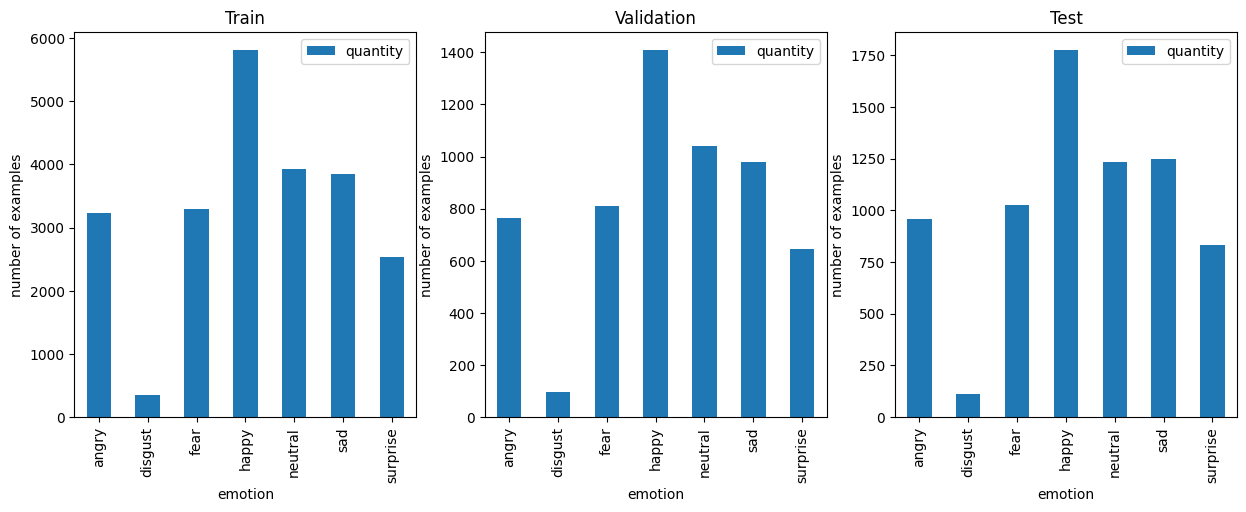

In [11]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
pd.DataFrame({'emotion':class_names[y_train], 'quantity': np.ones(y_train.shape)}).groupby('emotion').count().plot(ax=axes[0], kind='bar')
pd.DataFrame({'emotion':class_names[y_val], 'quantity': np.ones(y_val.shape)}).groupby('emotion').count().plot(ax=axes[1], kind='bar')
pd.DataFrame({'emotion':class_names[y_test], 'quantity': np.ones(y_test.shape)}).groupby('emotion').count().plot(ax=axes[2], kind='bar');

titles = ['Train','Validation','Test']
for i in range(3):
    axes[i].set_title(titles[i])
    axes[i].set_ylabel('number of examples'); 

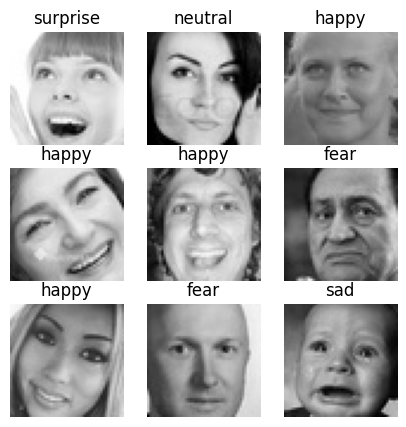

In [12]:
X_train = getNumpyArray(ds_train)
plt.figure(figsize=(5, 5))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train[i])
  plt.title(class_names[y_train[i]])
  plt.axis("off");

<a id="pretrained"></a>

# Pretrained model

---

In [138]:
model = tf.keras.Sequential([
                                hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5",
                                            trainable=False),
                                tf.keras.layers.Dense(len(class_names), activation='softmax')
                            ])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')],
)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_7 (KerasLayer)  multiple                  23561152  
                                                                 
 dense_38 (Dense)            multiple                  14343     
                                                                 
Total params: 23,575,495
Trainable params: 14,343
Non-trainable params: 23,561,152
_________________________________________________________________


In [ ]:
# history = model.fit(
#     ds_train_224,
#     validation_data=ds_val_224,
#     epochs=10,
# )
# model.save('models/my_model.h5')
# with open('models/history.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [16]:
model = load_model('models/my_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history.pkl', 'rb') as f:
    history2 = pickle.load(f)

In [17]:
X_train_224 = getNumpyArray(ds_train_224)
one_example_per_class = np.empty((len(class_names),)+X_train_224[0].shape)
for i in range(len(class_names)):
    one_example_per_class[i] = X_train_224[np.where(y_train == i)[0][0]]

In [18]:
# shapExplainer = shap.DeepExplainer(model,X_train_224[:100])
# shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
# shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.linearity_1d(0)
# shap_values = shapExplainer.shap_values(one_example_per_class)
# with open("shap_values_pretrained", "wb") as fp:
#     pickle.dump(shap_values, fp)

In [19]:
# with open("shap_values_pretrained", "rb") as fp:
#     shap_values = pickle.load(fp)

In [89]:
def evaluate(model,history,ds_train,ds_val,ds_test,shap_values=None,one_hot_encoded=False):
    y_train = getLabels(ds_train)
    y_val = getLabels(ds_val)
    y_test = getLabels(ds_test)

    f,axes = plt.subplots(1,2,figsize=(20,5))
    history_frame = pd.DataFrame(history)
    history_frame.loc[:, ['loss', 'val_loss']].plot(ax=axes[0])
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot(ax=axes[1]);

    if(one_hot_encoded):
        y_train = np.argmax(y_train,axis=1)
        y_val = np.argmax(y_val,axis=1)
        y_test = np.argmax(y_test,axis=1)
    print("Calculating training results:")
    y_train_predictions = np.argmax(model.predict(ds_train),axis=1)
    print("Calculating validation results:")
    y_val_predictions = np.argmax(model.predict(ds_val),axis=1)
    print("Calculating test results:")
    y_test_predictions = np.argmax(model.predict(ds_test),axis=1)

    f, axes= plt.subplots(1,3,figsize=(20,5))
    accuracies = []
    accuracies.append(round(100*accuracy_score(y_train, y_train_predictions),2))
    mat = confusion_matrix(y_train, y_train_predictions)
    sns.heatmap(mat, annot=True, fmt='g', ax=axes[0]);

    accuracies.append(round(100*accuracy_score(y_val, y_val_predictions),2))
    mat = confusion_matrix(y_val, y_val_predictions)
    sns.heatmap(mat, annot=True, fmt='g', ax=axes[1]);

    accuracies.append(round(100*accuracy_score(y_test, y_test_predictions),2))
    mat = confusion_matrix(y_test,y_test_predictions)
    sns.heatmap(mat, annot=True, fmt='g', ax=axes[2]);

    for i in range(3):
        axes[i].set_xlabel('Predicted emotions');axes[i].set_ylabel('True emotions'); 
        axes[i].set_title('Confusion Matrix '+titles[i]+ " (accuracy: {}%)".format(accuracies[i])); 
        axes[i].xaxis.set_ticklabels(class_names); axes[i].yaxis.set_ticklabels(class_names);
    if(shap_values is not None):
        fig,axes = plt.subplots(1,len(class_names)+1,figsize=(20,3))
        axes[0].set_axis_off()
        axes[0].set_title("REAL CLASSES ->")
        image = plt.imread('images/predicted.png')
        axes[0].imshow(image)
        for i in range(1,len(class_names)+1):
            axes[i].set_axis_off()
            axes[i].set_title(class_names[i-1])
            axes[i].imshow(one_example_per_class[i-1])
        shap.image_plot(shap_values,one_example_per_class)
        

Calculating training results:


2023-04-28 18:53:07.855471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


359/359 [==============================] - 250s 691ms/step
Calculating validation results:
90/90 [==============================] - 68s 763ms/step
Calculating test results:
113/113 [==============================] - 84s 749ms/step


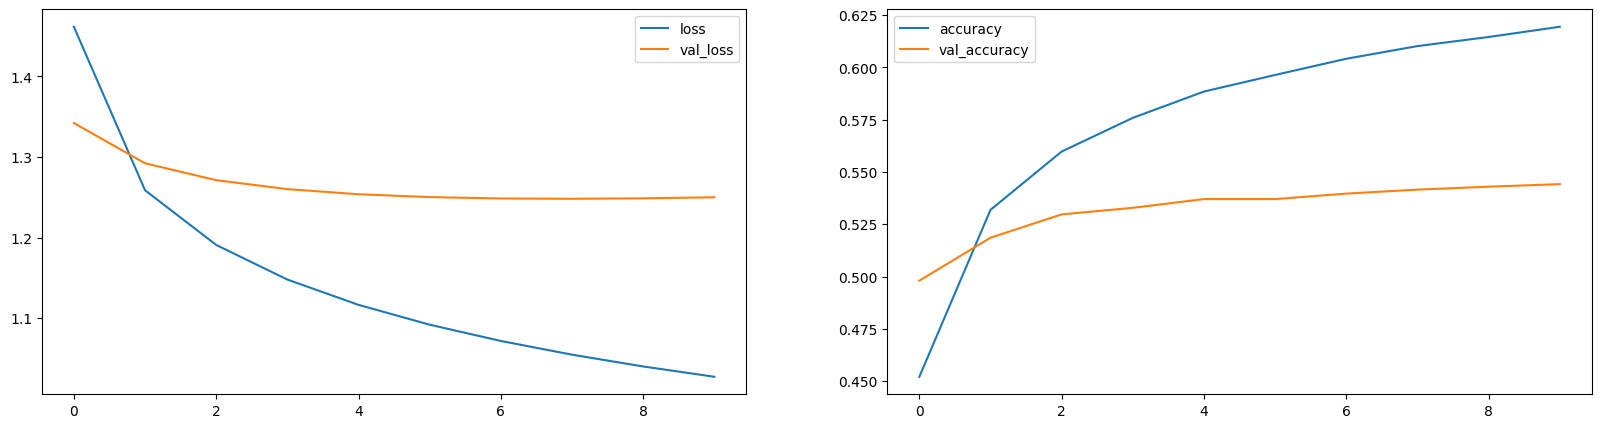

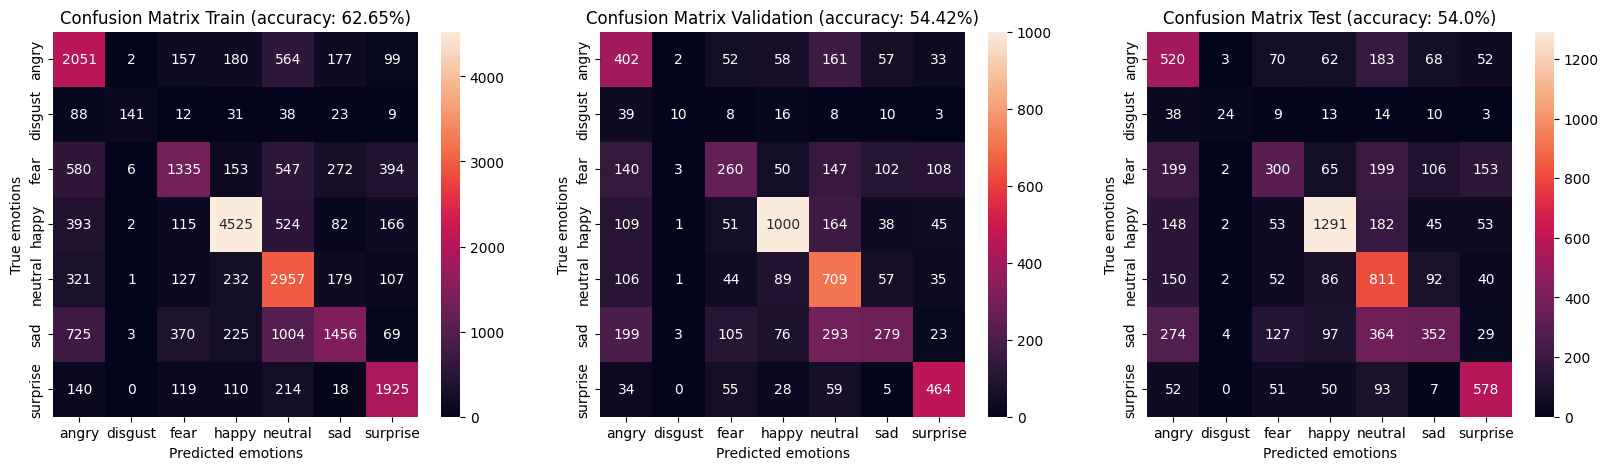

In [100]:
evaluate(model,history2,ds_train_224,ds_val_224,ds_test_224)

There are very few "disgust" examples so they're the most difficult ones to predict, on the other hand "happy" is widely represented so it predicts them very well

<a id="data_augmentation"></a>

# Data augmentation

---

In [16]:
model = load_model('models/my_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history.pkl', 'rb') as f:
    history2 = pickle.load(f)

In [15]:
X_train_224 = getNumpyArray(ds_train_224)
X_val_224 = getNumpyArray(ds_val_224)
X_test_224 = getNumpyArray(ds_test_224)
y_train_224 = getLabels(ds_train_224)
y_val_224 = getLabels(ds_val_224)
y_test_224 = getLabels(ds_test_224)

In [ ]:
# train_datagen = ImageDataGenerator(horizontal_flip=True,
#                                    shear_range=5)
# train_datagen.fit(X_train_224)

# history = model.fit(train_datagen.flow(X_train_224, y_train_224),
#                               epochs=5,
#                               validation_data=ds_val_224)
# model.save('models/my_model_augmented.h5')
# with open('models/history_augmented.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [128]:
model = load_model('models/my_model_augmented.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_augmented.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:


2023-04-30 21:04:34.806764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


359/359 [==============================] - 184s 510ms/step
Calculating validation results:
90/90 [==============================] - 47s 523ms/step
Calculating test results:
113/113 [==============================] - 61s 546ms/step


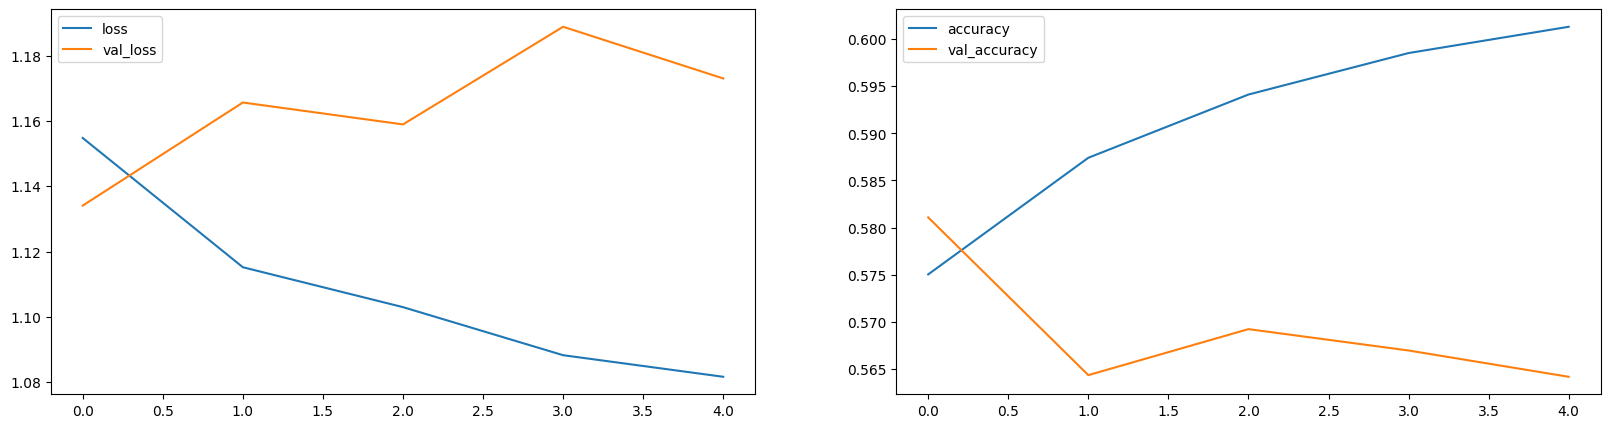

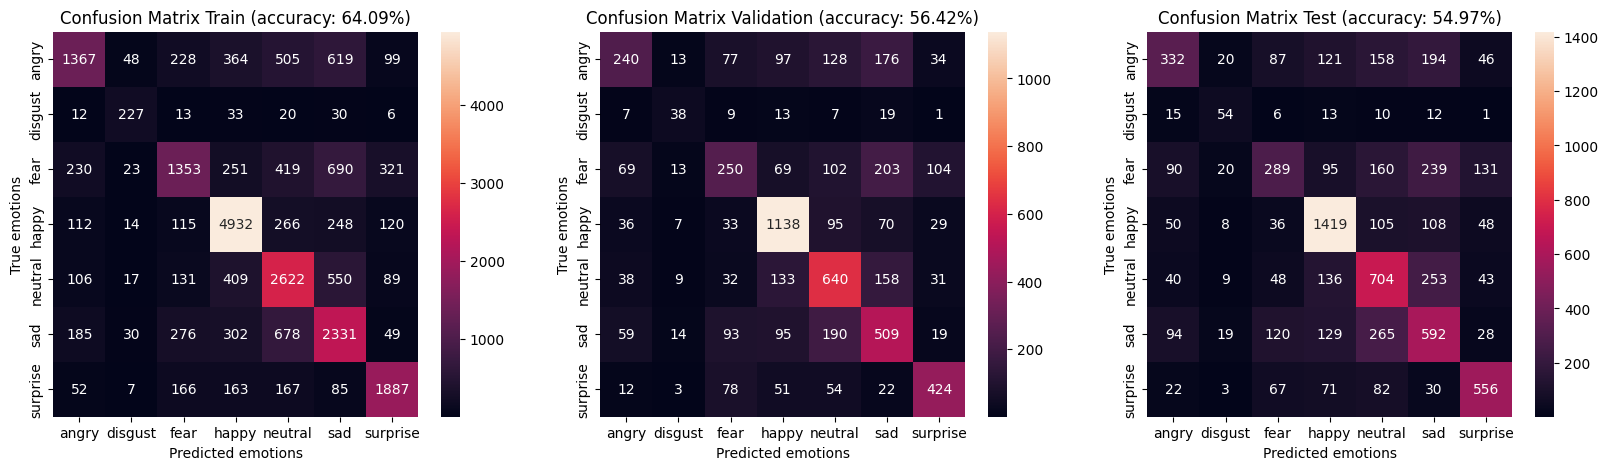

In [129]:
evaluate(model,history2,ds_train_224,ds_val_224,ds_test_224)

<a id="fine_tuning"></a>

# Fine tuning

---

In [95]:
model = tf.keras.Sequential([
                                hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5",
                                            trainable=True),
                                tf.keras.layers.Dense(len(class_names), activation='softmax')
                            ])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')],
)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  multiple                  23561152  
                                                                 
 dense_27 (Dense)            multiple                  14343     
                                                                 
Total params: 23,575,495
Trainable params: 23,522,375
Non-trainable params: 53,120
_________________________________________________________________


In [112]:
# number_layer_to_unfreeze = 40

# resnet_50= tf.keras.applications.ResNet50(include_top=True)

# for each_layer in resnet_50.layers[:-number_layer_to_unfreeze]:
#         each_layer.trainable=False
# for each_layer in resnet_50.layers[-number_layer_to_unfreeze:]:
#         each_layer.trainable=True

# model = tf.keras.Sequential([
#         resnet_50,
#         Dense(len(class_names), activation='softmax')
# ])

# model.summary()

# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy'],
# )

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense_34 (Dense)            (None, 7)                 7007      
                                                                 
Total params: 25,643,719
Trainable params: 17,297,735
Non-trainable params: 8,345,984
_________________________________________________________________


In [ ]:
# history = model.fit(
#     ds_train_224,
#     validation_data=ds_val_224,
#     epochs=5,
# )
# model.save('models/my_model_fine_tuned.h5')
# with open('models/history_fine_tuned.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [182]:
model = load_model('models/my_model_fine_tuned.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_fine_tuned.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:


2023-04-28 22:05:16.544016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


359/359 [==============================] - 226s 624ms/step
Calculating validation results:
90/90 [==============================] - 64s 714ms/step
Calculating test results:
113/113 [==============================] - 82s 732ms/step


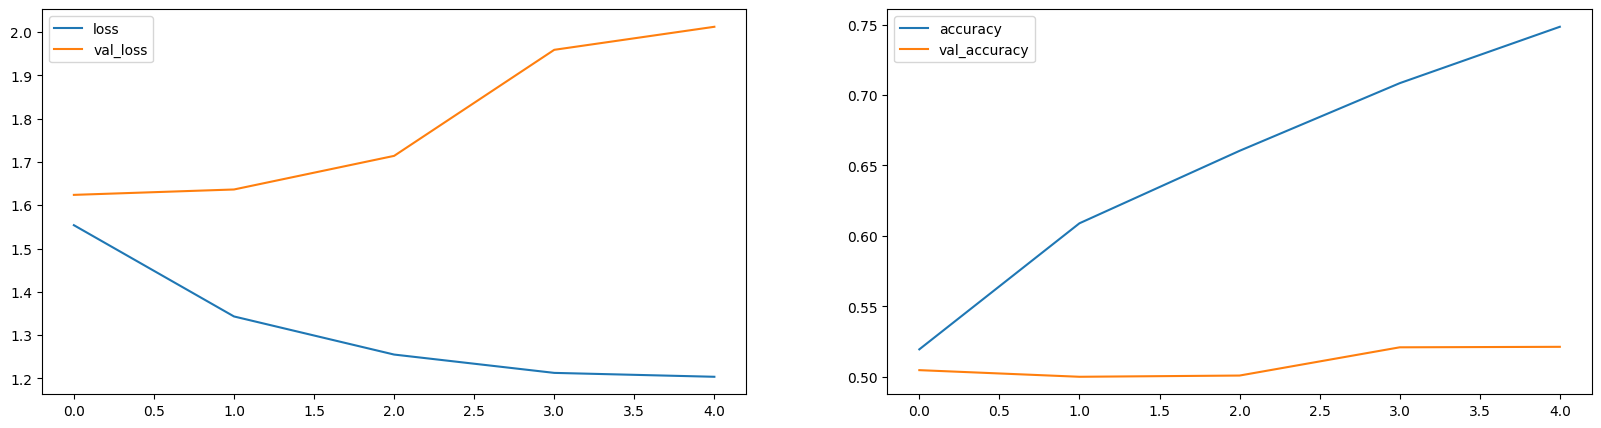

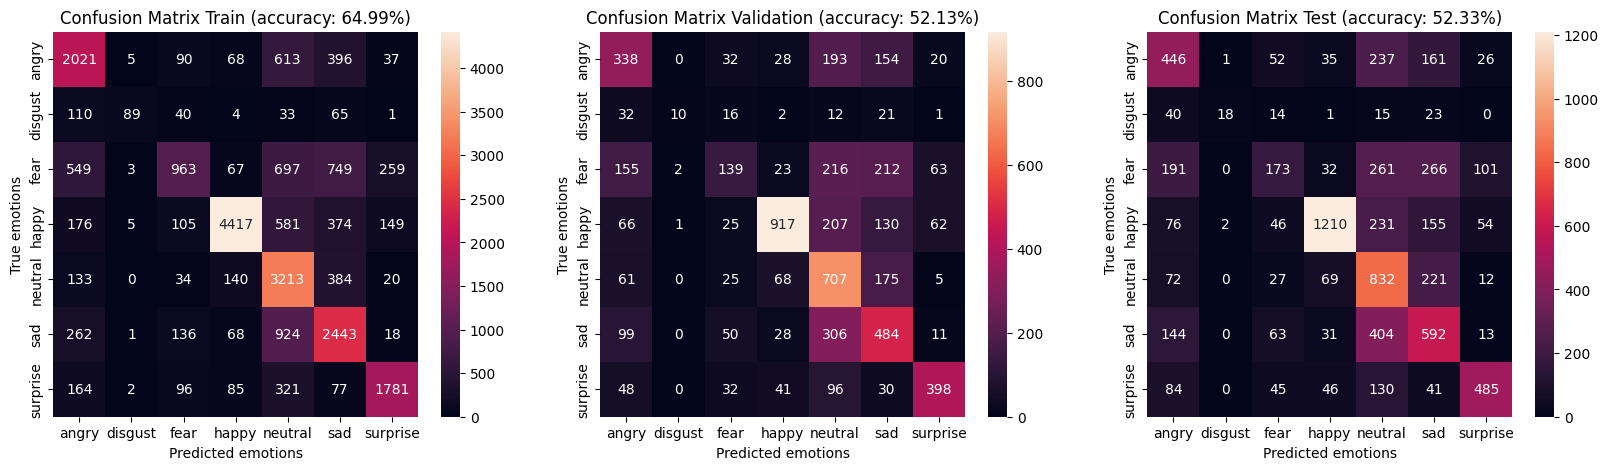

In [183]:
evaluate(model,history2,ds_train_224,ds_val_224,ds_test_224)

<a id="customized_model"></a>

# Customized CNN

---

In [140]:
def createModel(loss='sparse_categorical_crossentropy'):
    tf.random.set_seed(1)
    model= tf.keras.models.Sequential([
        preprocessing.Normalization(),

        Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
        Conv2D(64,(3,3), padding='same', activation='relu' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128,(5,5), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
            
        Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(256,activation = 'relu'),
        BatchNormalization(),
        Dropout(0.25),
            
        Dense(512,activation = 'relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(7, activation='softmax')
    ])
    model.build([None, 48, 48, 1])
    model.compile(
        # its default learning rate is already 0.001
        optimizer=Adam(),
        loss=loss,
        metrics=['accuracy'],
    )
    return model

In [54]:
# X_train = getNumpyArray(ds_train)
# y_train = getLabels(ds_train)
# X_val = getNumpyArray(ds_val)
# y_val = getLabels(ds_val)
# X = np.vstack((X_train,X_val))
# y = np.concatenate((y_train,y_val))

# model = KerasClassifier(model=createModel,batch_size=64, epochs=5)
# learn_rate = [0.001, 0.0001,0.00001]
# param_grid = dict(optimizer__learning_rate=learn_rate)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1,cv=3)
# grid_result = grid.fit(X,y)

# joblib.dump(grid.best_params_, 'best_learning_rate_custom_model.pkl')

['best_learning_rate_custom_model.pkl']

In [57]:
best_learning_rate = joblib.load('best_learning_rate_custom_model.pkl')
print(f"The best learning rate amongst the ones that have been tried is {best_learning_rate['optimizer__learning_rate']}")

The best learning rate amongst the ones that have been tried is 0.001


In [141]:
model= createModel()
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  multiple                 3         
 ion)                                                            
                                                                 
 conv2d_20 (Conv2D)          multiple                  320       
                                                                 
 conv2d_21 (Conv2D)          multiple                  18496     
                                                                 
 batch_normalization_24 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                     

In [142]:
# history = model.fit(
#     ds_train,
#     validation_data=ds_val,
#     epochs=30,
# )
# model.save('models/my_model_custom.h5')
# with open('models/history_custom.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Epoch 1/30


2023-04-30 21:20:47.251942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


180/180 [==============================] - ETA: 0s - loss: 6.2142 - accuracy: 0.2447

2023-04-30 21:21:34.026795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


180/180 [==============================] - 51s 270ms/step - loss: 6.2142 - accuracy: 0.2447 - val_loss: 3.7890 - val_accuracy: 0.2453
Epoch 2/30
180/180 [==============================] - 46s 254ms/step - loss: 2.4037 - accuracy: 0.3927 - val_loss: 3.1000 - val_accuracy: 0.2449
Epoch 3/30
180/180 [==============================] - 46s 255ms/step - loss: 1.9761 - accuracy: 0.4857 - val_loss: 2.8150 - val_accuracy: 0.3024
Epoch 4/30
180/180 [==============================] - 45s 252ms/step - loss: 1.9330 - accuracy: 0.5444 - val_loss: 2.6608 - val_accuracy: 0.3691
Epoch 5/30
180/180 [==============================] - 47s 260ms/step - loss: 1.8907 - accuracy: 0.5885 - val_loss: 3.1479 - val_accuracy: 0.3078
Epoch 6/30
180/180 [==============================] - 47s 261ms/step - loss: 1.8346 - accuracy: 0.6399 - val_loss: 3.3026 - val_accuracy: 0.3623
Epoch 7/30
180/180 [==============================] - 47s 263ms/step - loss: 1.8285 - accuracy: 0.6718 - val_loss: 2.9264 - val_accuracy: 0.3

In [22]:
model = load_model('models/my_model_custom.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_custom.pkl', 'rb') as f:
    history2 = pickle.load(f)

In [ ]:
one_example_per_class = np.empty((len(class_names),)+X_train[0].shape)
for i in range(len(class_names)):
    one_example_per_class[i] = X_train[np.where(y_train == i)[0][0]]

In [23]:
# shapExplainer = shap.DeepExplainer(model,X_train[:100])
# shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
# shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.linearity_1d(0)
# shap_values = shapExplainer.shap_values(one_example_per_class)
# with open("shap_values", "wb") as fp:
#     pickle.dump(shap_values, fp)

In [24]:
with open("shap_values", "rb") as fp:
    shap_values = pickle.load(fp)

Calculating training results:
  1/180 [..............................] - ETA: 40s

2023-04-27 10:26:22.746574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


180/180 [==============================] - 13s 71ms/step
Calculating validation results:
45/45 [==============================] - 3s 73ms/step
Calculating test results:
57/57 [==============================] - 4s 71ms/step


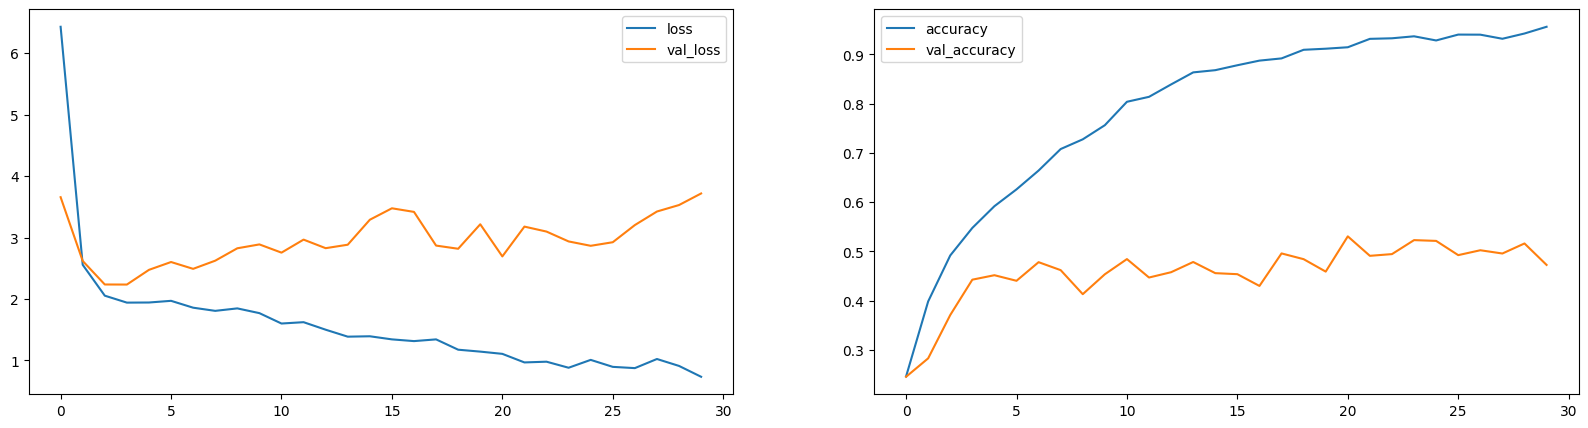

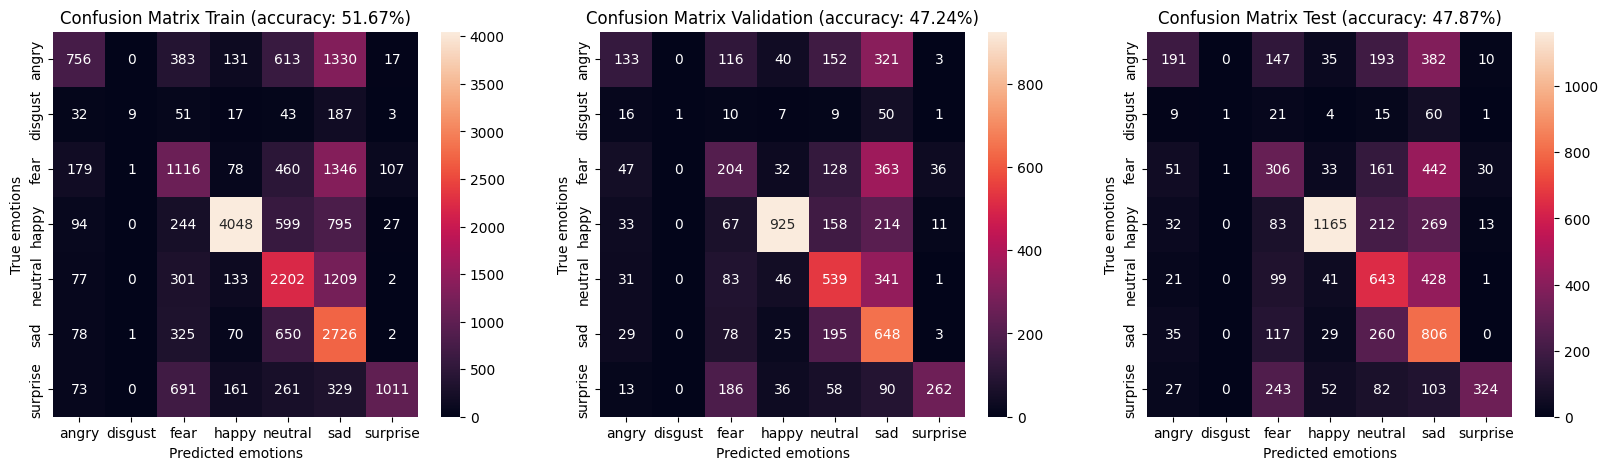

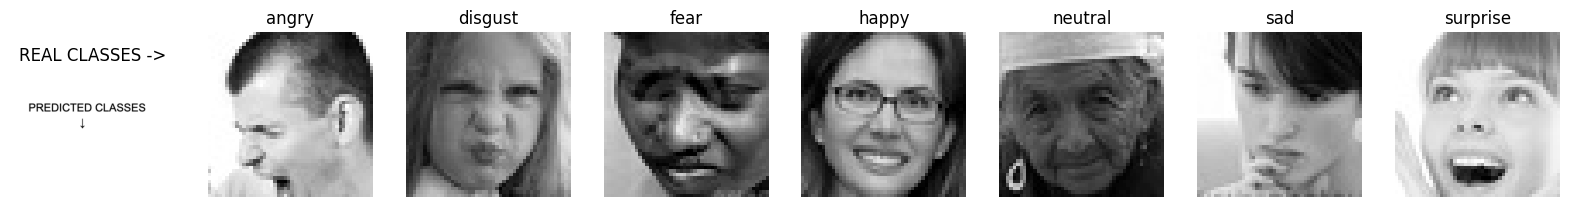

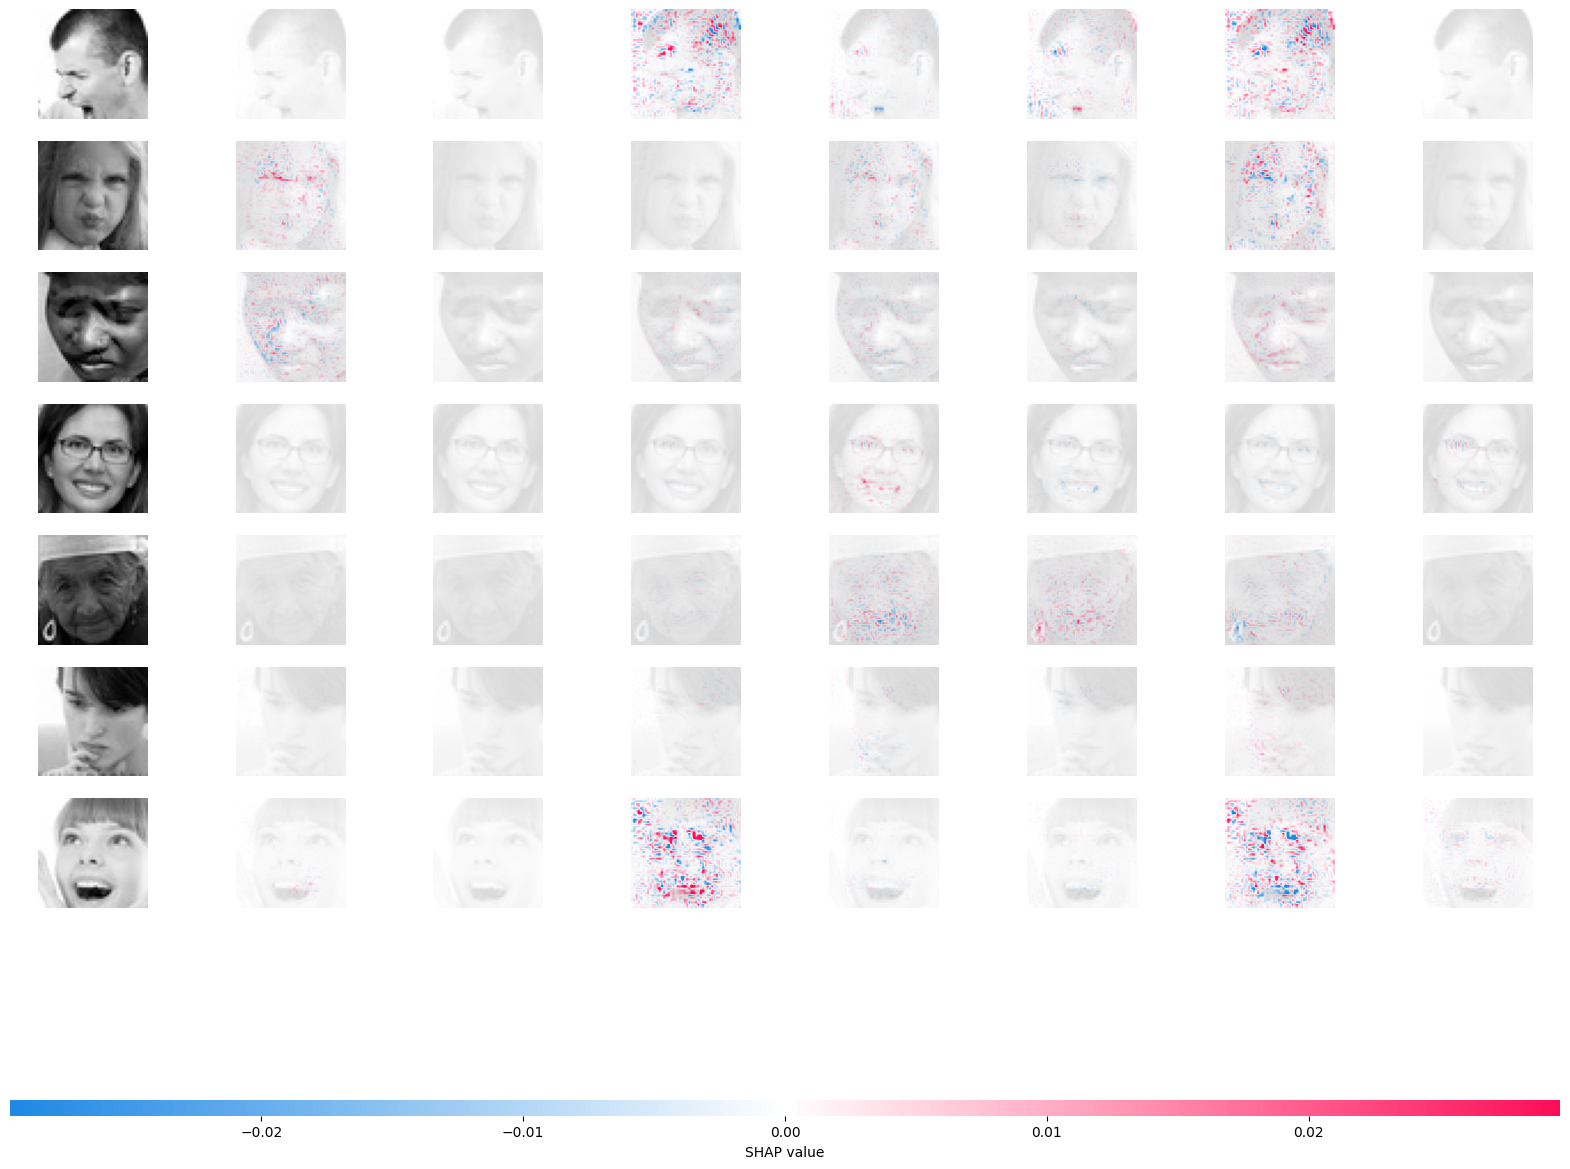

In [25]:
evaluate(model,history2,ds_train,ds_val,ds_test,shap_values=shap_values)

<a id="label_smoothing"></a>

# Label smoothing

---

In [17]:
ds_train_categorical,ds_val_categorical,ds_test_categorical,class_names = load_data(label_mode='categorical')

Found 28708 files belonging to 7 classes.
Using 22967 files for training.
Found 28708 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [65]:
model= createModel(CategoricalCrossentropy(label_smoothing=0.1))

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  multiple                 7         
 ion)                                                            
                                                                 
 conv2d_15 (Conv2D)          multiple                  896       
                                                                 
 conv2d_16 (Conv2D)          multiple                  18496     
                                                                 
 batch_normalization_18 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                     

In [68]:
# history = model.fit(
#     ds_train_categorical,
#     validation_data=ds_val_categorical,
#     epochs=30,
# )
# model.save('models/my_model_custom_label_smoothed.h5')
# with open('models/history_custom_label_smoothed.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [71]:
model = load_model('models/my_model_custom_label_smoothed.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_custom_label_smoothed.pkl', 'rb') as f:
    history2 = pickle.load(f)

Calculating training results:
359/359 [==============================] - 12s 35ms/step
Calculating validation results:
90/90 [==============================] - 3s 35ms/step
Calculating test results:
113/113 [==============================] - 4s 35ms/step


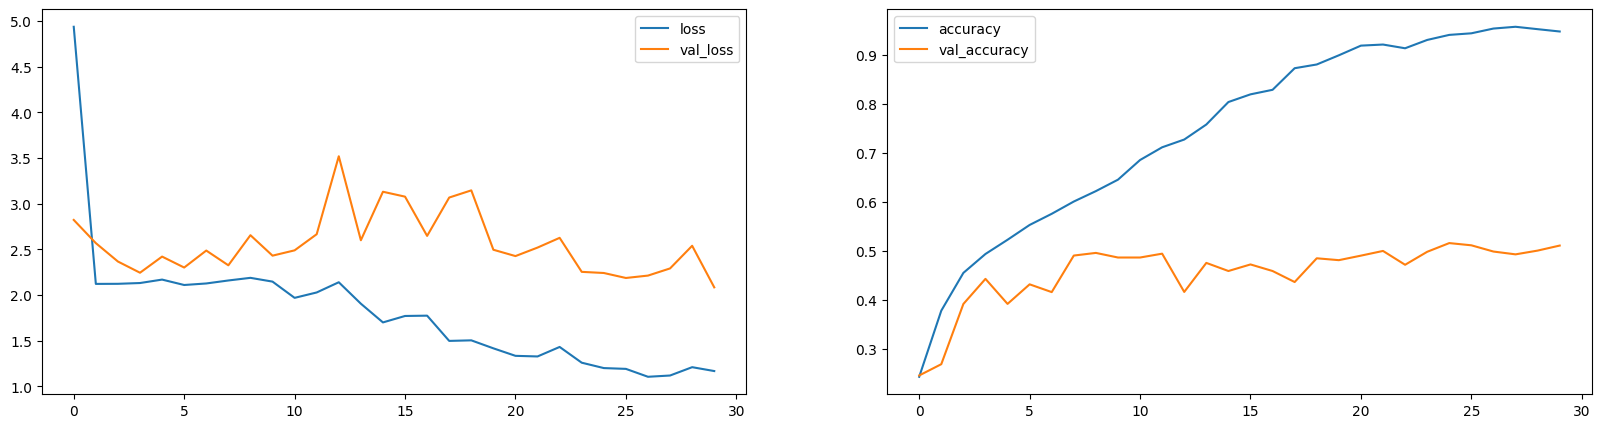

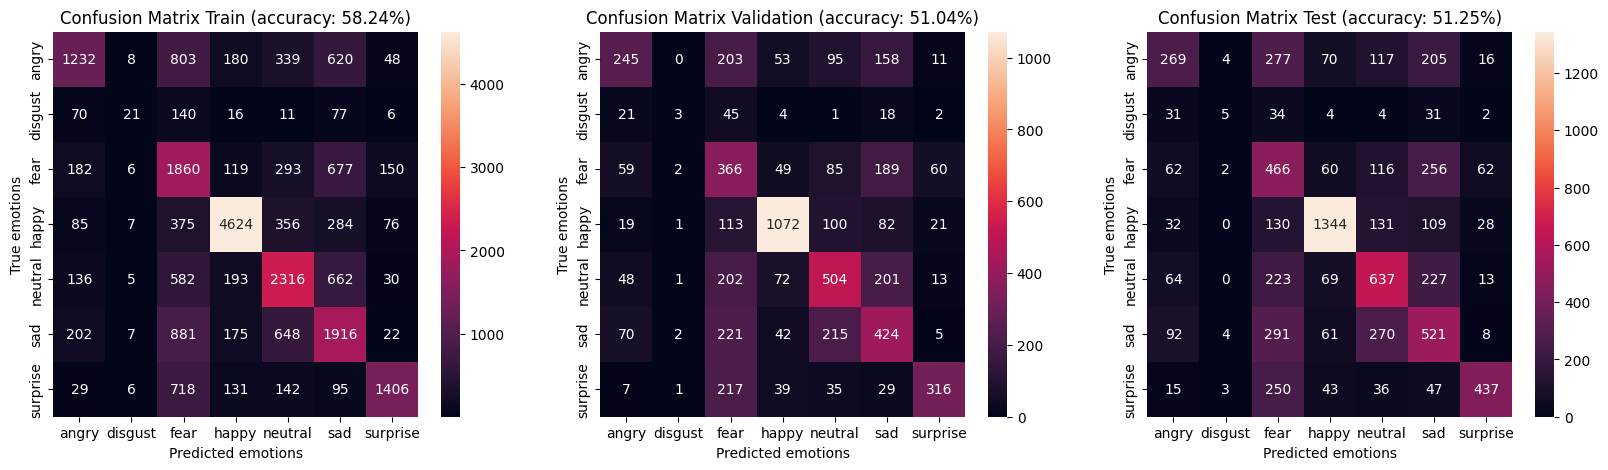

In [88]:
evaluate(model,history2,ds_train_categorical,ds_val_categorical,ds_test_categorical,one_hot_encoded=True)

<a id="TTA"></a>

# Test Time Augmentation

---

In [15]:
model = load_model('models/my_model_custom_label_smoothed.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history_custom_label_smoothed.pkl', 'rb') as f:
    history2 = pickle.load(f)

In [105]:
def predictWithTTA(test_set,model,data_generator,tta_steps=3,batch_size=128):
    x_test = getNumpyArray(test_set)
    predictions = []
    for i in tqdm(range(tta_steps)):
        preds = model.predict(data_generator.flow(x_test, batch_size=batch_size, shuffle=False), steps = len(x_test)/batch_size)
        predictions.append(preds)
    predictions = np.mean(predictions, axis=0)
    return predictions

In [109]:
def calculateAccuracyWithTTA(test_set,model):
    predictions = predictWithTTA(test_set,model,ImageDataGenerator(horizontal_flip=True,shear_range=5))
    int_predictions = np.argmax(predictions,axis=1)
    print(f"Accuracy obtained with Test Time Augmentation is: {round(100*accuracy_score(np.argmax(getLabels(ds_test_categorical),axis=1), int_predictions),2)}%")

In [110]:
calculateAccuracyWithTTA(ds_test_categorical,model)

  0%|          | 0/3 [00:00<?, ?it/s]

56/56 [==============================] - 6s 105ms/step


 33%|███▎      | 1/3 [00:05<00:11,  5.92s/it]

56/56 [==============================] - 6s 104ms/step


 67%|██████▋   | 2/3 [00:11<00:05,  5.86s/it]

56/56 [==============================] - 6s 104ms/step


100%|██████████| 3/3 [00:17<00:00,  5.85s/it]

Accuracy obtained with Test Time Augmentation is: 51.09%
